<a href="https://colab.research.google.com/github/unalkizil/ukizil/blob/master/predictionmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


### tfdocs installation için komut satırına (pip install git+https://github.com/tensorflow/docs) yazılır. ancak öncelikle github install edilmeli. Bu da (https://gitforwindows.org/) adresinden sağlanabilir

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\UnalKIZIL\\.keras\\datasets\\auto-mpg.data'

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [ ]:
dataset = dataset.dropna()

In [ ]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

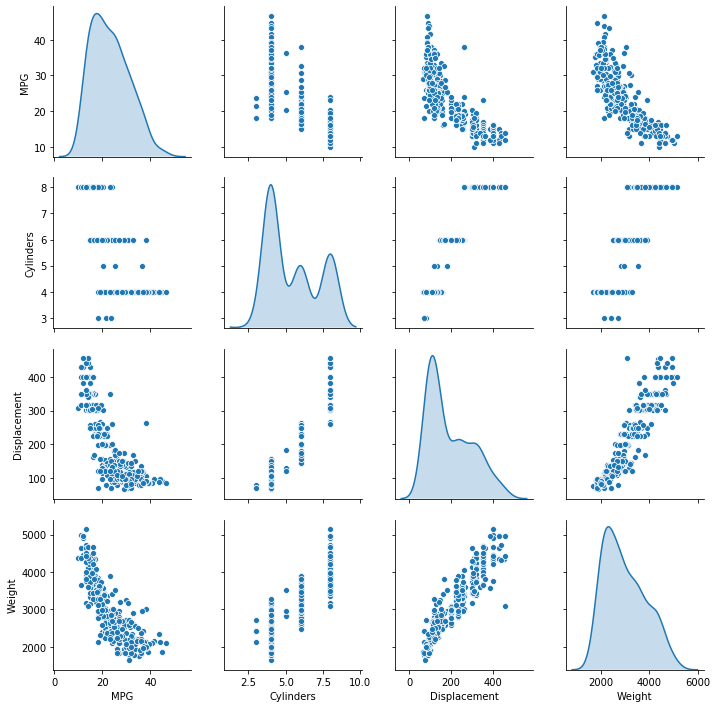

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 6.3610816e-01],
       [ 5.0190204e-01],
       [ 4.4851235e-01],
       [ 8.6364841e-01],
       [ 6.1169291e-01],
       [-7.6571852e-04],
       [ 6.5334129e-01],
       [ 5.6131089e-01],
       [-3.6374874e-02],
       [ 4.5385116e-01]], dtype=float32)

In [ ]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:548.6337,  mean_absolute_error:22.1816,  mean_squared_error:548.6337,  val_loss:535.6227,  val_mean_absolute_error:21.9169,  val_mean_squared_error:535.6227,  
....................................................................................................
Epoch: 100, loss:6.3125,  mean_absolute_error:1.7512,  mean_squared_error:6.3125,  val_loss:8.4958,  val_mean_absolute_error:2.1569,  val_mean_squared_error:8.4958,  
....................................................................................................
Epoch: 200, loss:5.4810,  mean_absolute_error:1.6420,  mean_squared_error:5.4810,  val_loss:8.3177,  val_mean_absolute_error:2.1918,  val_mean_squared_error:8.3177,  
....................................................................................................
Epoch: 300, loss:4.8431,  mean_absolute_error:1.4893,  mean_squared_error:4.8431,  val_loss:8.3207,  val_mean_absolute_error:2.1397,  val_mean_squared_error:8.3207,  
....................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,3.159347,1.113783,3.159347,8.702149,2.223202,8.702149,995
996,2.863285,1.040629,2.863285,8.452569,2.194468,8.452569,996
997,2.851938,1.054249,2.851938,9.018724,2.302800,9.018723,997
998,2.846093,1.037340,2.846093,8.627078,2.221915,8.627077,998
999,2.759951,1.050267,2.759951,8.922813,2.294355,8.922812,999


In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

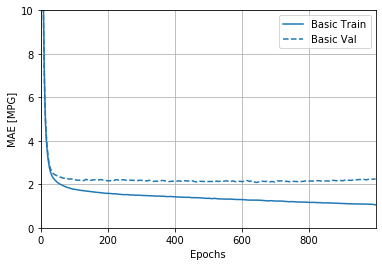

In [ ]:
plotter.plot({'Basic': history}, metric = "mean_absolute_error")
plt.ylim([0, 10])
plt.ylabel("MAE [MPG]")

Text(0, 0.5, 'MSE [MPG^2]')

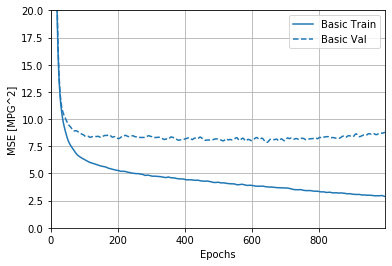

In [ ]:
plotter.plot({'Basic': history}, metric = "mean_squared_error")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:577.2292,  mean_absolute_error:22.6302,  mean_squared_error:577.2292,  val_loss:573.9150,  val_mean_absolute_error:22.4501,  val_mean_squared_error:573.9150,  
......................................................................................

Text(0, 0.5, 'MAE [MPG]')

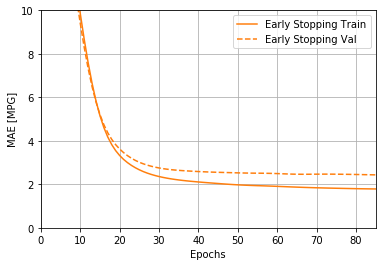

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric = "mean_absolute_error")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [ ]:
loss, mean_absolute_error, mean_squared_error = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mean_absolute_error))

78/78 - 0s - loss: 7.1856 - mean_absolute_error: 2.0439 - mean_squared_error: 7.1856
Testing set Mean Abs Error:  2.04 MPG


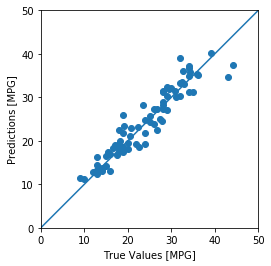

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

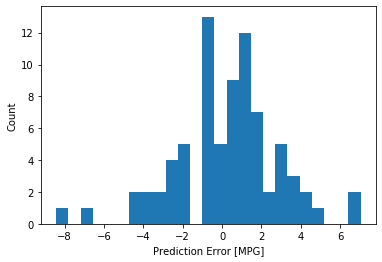

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

#### Keras Regression Metrics
Below is a list of the metrics that you can use in Keras on regression problems.

Mean Squared Error: mean_squared_error, MSE or mse
Mean Absolute Error: mean_absolute_error, MAE, mae
Mean Absolute Percentage Error: mean_absolute_percentage_error, MAPE, mape
Cosine Proximity: cosine_proximity, cosine

#### Keras Classification Metrics
Below is a list of the metrics that you can use in Keras on classification problems.

Binary Accuracy: binary_accuracy, acc
Categorical Accuracy: categorical_accuracy, acc
Sparse Categorical Accuracy: sparse_categorical_accuracy
Top k Categorical Accuracy: top_k_categorical_accuracy (requires you specify a k parameter)
Sparse Top k Categorical Accuracy: sparse_top_k_categorical_accuracy (requires you specify a k parameter)

### orijinal belge: https://www.tensorflow.org/tutorials/keras/regression